# Feature Selection in Uplift Modeling Using Booking Data

In this notebook we apply various stationary (non-dynamic) and non-stationary (dynamic) feature selection methods on synthetic datasets

## [<span style="color:black; text-decoration:underline">1. Divergence Filters</span>](#First)  

## [<span style="color:black; text-decoration:underline">2. Permutation with Uplift Random Forest</span>](#Second)

## [<span style="color:black; text-decoration:underline">3. Net Information Value</span>](#Third)

## [<span style="color:black; text-decoration:underline">4. Uplift Curve</span>](#Fourth)

## [<span style="color:black; text-decoration:underline">5. Feature Importance over Time (FIoT) with Divergence Filter</span>](#Fifth)

#### Imports

In [22]:
from pyspark.sql import functions as F, types as T

from pysparkling import H2OContext, H2OConf

import h2o

import matplotlib.pyplot as plt

import pandas as pd

from upliftml.datasets import simulate_randomized_trial
from upliftml.feature_selection.stationary_methods import (
    DivergenceFilter,
    PermutationUpliftRandomForestWrapper,
    UpliftCurveFilter,
    NetInformationValueFilter
)

#### Configurations

In [4]:
spark = (SparkSession
         .builder
         .enableHiveSupport()
         .getOrCreate()
         )

In [ ]:
def init_h2o():
    conf = (H2OConf()
            .setInternalClusterMode()
            .setCloudTimeout(12000)
           )
    context = H2OContext.getOrCreate(conf)
    return context

context = init_h2o()

#### Helper Functions

In [8]:
def plot_variable_contribution(feature_list, features_dict):
    num_rows = 4
    num_cols = 2
    figure, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    i = 0
    j = 0
    i = 0
    for row in range(num_rows):
        for col in range(num_cols):
            feature = feature_list[i]
            i += 1
            for k, v in features_dict[feature].items():
                x = str(round(k, 4)) if type(k) != str else k
                axes[row, col].bar(x, v)
                axes[row, col].set_title(feature)
    plt.xticks(rotation=45)
    plt.tight_layout()

In [7]:
def feature_importance_plot(df, feature_col='feature', score_col='score'):
    figure, axis = plt.subplots(figsize=(6, 6))
    
    # Sort the feature importances in ascending order
    df_asc = df.sort_values(by=score_col, ascending=True)

    axis.barh(df_asc[feature_col], df_asc[score_col])

## Create Synthetic Dataset

We create a synthetic dataset with 10 features. The first 5 features, that is, feature_1 - feature_5, determine the treatment heterogeneity and thus, are most important. The remaining features are unimportant.

In [12]:
df_pd = pd.DataFrame()

nr_days = 7
for i in range(7):
    pdf = simulate_randomized_trial(n=5000, p=10, binary_outcome=True)
    pdf.columns = ['treatment', 'outcome', 'propensity', 'expected_outcome', 'actual_cate', 'feature_1_relevant',
                   'feature_2_relevant', 'feature_3_relevant', 'feature_4_relevant', 'feature_5_relevant',
                   'feature_6_irrelevant', 'feature_7_irrelevant', 'feature_8_irrelevant', 'feature_9_irrelevant',
                   'feature_10_irrelevant']
    pdf.drop(['propensity', 'expected_outcome', 'actual_cate'], axis=1, inplace=True)
    pdf['day'] = (i + 1)
    
    if df_pd.empty:
        df_pd = pdf.copy()
    else:
        df_pd = pd.concat([df_pd, pdf], ignore_index=True)

In [13]:
df = spark.createDataFrame(df_pd)
df.limit(5).toPandas() 

,treatment,outcome,feature_1_relevant,feature_2_relevant,feature_3_relevant,feature_4_relevant,feature_5_relevant,feature_6_irrelevant,feature_7_irrelevant,feature_8_irrelevant,feature_9_irrelevant,feature_10_irrelevant,day
0,0,1,2.521973,-0.252538,-1.356451,0.502540,0.597292,1.979342,-0.395883,0.530747,-0.396860,-0.347870,1
1,0,1,-0.265169,0.833194,0.460747,2.135084,0.838562,-1.458075,0.334309,0.996556,-1.757002,0.007824,1
2,0,1,-0.450305,0.656554,1.756982,0.402179,1.845892,1.785042,0.202718,0.309199,0.026175,0.150281,1
3,0,0,-0.029022,-0.945955,-0.289361,-1.234299,0.289911,-0.738921,0.519272,0.188176,0.536102,1.215270,1
4,1,1,-0.799217,-1.400608,-0.438060,0.021618,1.103500,0.171329,-0.867671,-0.202920,-1.295424,0.689572,1


In [16]:
feature_names = df_pd.columns.to_list()[2:-1]

In [18]:
# Set the number of bins for bin-based feature selection methods globally
n_bins = 10

## <span id="First">1. Divergence Filter</span>

Use the Divergence Filter, proposed in Zhao et al. (2022), as a feature selection method. We can select different methods for calculating divergence, that is, either KL, ED, or Chi.

### 1.1 Kullback-Leibler Divergence

In [19]:
divergence_filter_kl = DivergenceFilter(n_bins=n_bins, method="KL")

In [20]:
fi_df_kl, fi_variables_df_kl = divergence_filter_kl.calculate_feature_importance(df, feature_names)

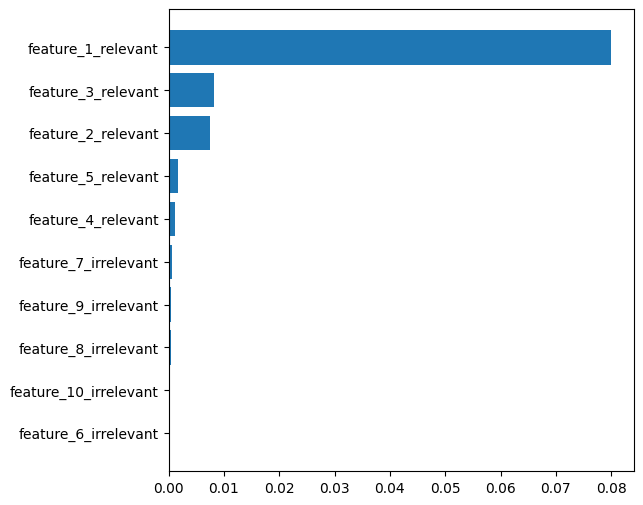

In [24]:
feature_importance_plot(fi_df_kl)

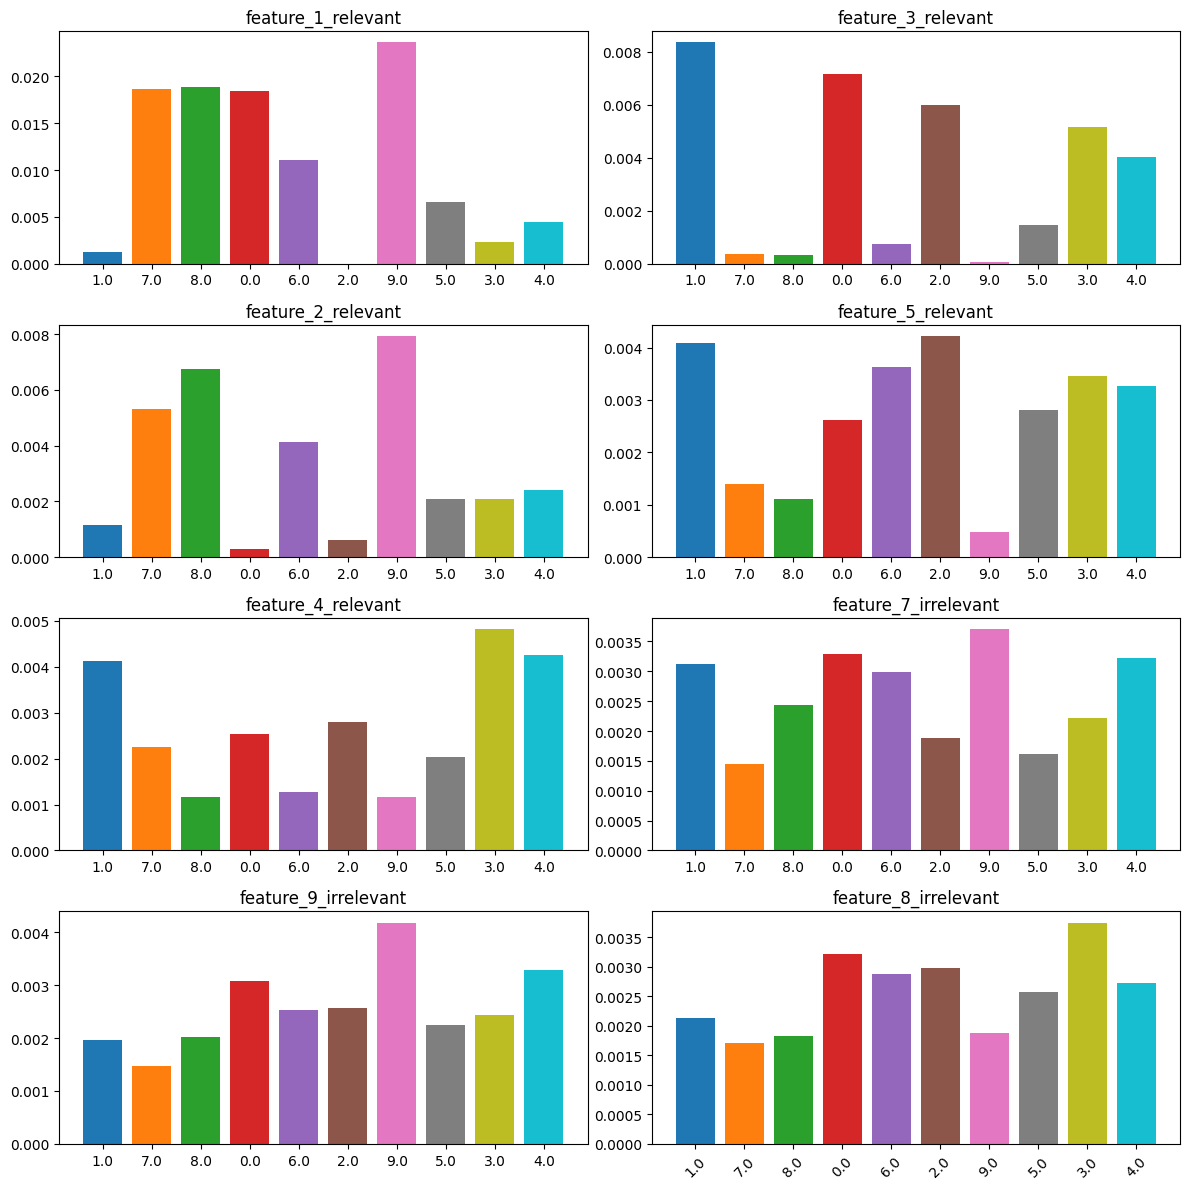

In [25]:
plot_variable_contribution(fi_df_kl.iloc[0:8, 0].to_list(), fi_variables_df_kl)

#### 1.2 Euclidean Distance

In [26]:
divergence_filter_ed = DivergenceFilter(n_bins=n_bins, method="ED")

In [27]:
fi_df_ed, fi_variables_df_ed = divergence_filter_ed.calculate_feature_importance(df, feature_names)

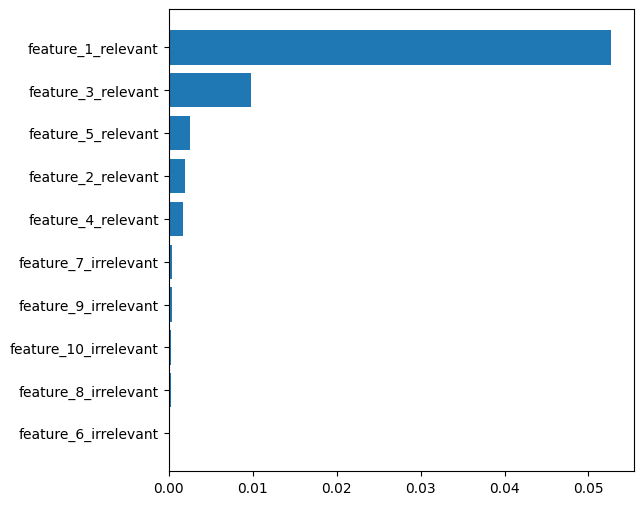

In [28]:
feature_importance_plot(fi_df_ed)

#### 1.3 Chi-Sqaured Divergence

In [29]:
divergence_filter_chi = DivergenceFilter(n_bins=n_bins, method="Chi")

In [30]:
fi_df_chi, fi_variables_df_chi = divergence_filter_chi.calculate_feature_importance(df, feature_names)

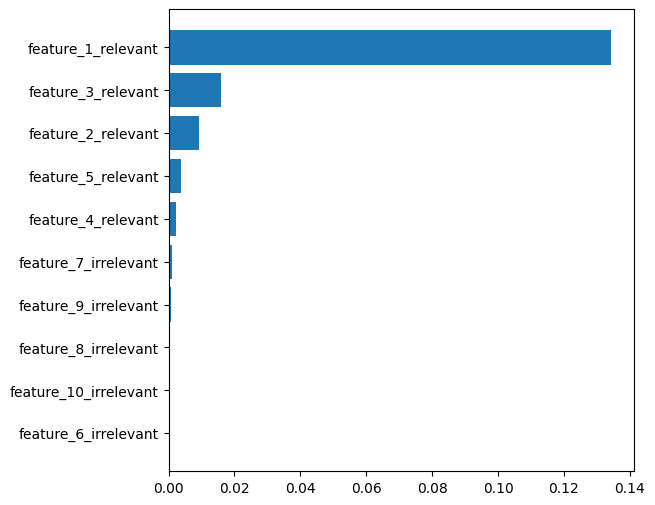

In [31]:
feature_importance_plot(fi_df_chi)

## <span id="Second">2. Permutation with Uplift Random Forest Wrapper</span>

Use the Permutation method with Uplift Random Forest as a wrapper feature selection method.

In [32]:
categorical_features = ['treatment', 'outcome']

In [33]:
# Hyperparameter for Distributed Uplift Random Forest
durf_dict = {
    'ntrees': 5,
    'max_depth': 5,
    'treatment_column': 'treatment',
    'uplift_metric': 'kl',  # Can either be 'kl', 'euclidean', or 'chi_squared'
    'nbins_top_level': 512,
    'nbins': 10,
    'min_rows': 1,
    'mtries': -1,
    'sample_rate': 0.5,
    'sample_rate_per_class': None,
    'col_sample_rate_per_tree': 0.5,
    'auuc_type': "qini",
    'auuc_nbins': 100,
    'ignore_const_cols': False
}

In [34]:
permutation_urf = PermutationUpliftRandomForestWrapper(durf_dict=durf_dict,
                                                       factor_list=categorical_features,
                                                       n_repeats=3)

In [35]:
fi_non_dynamicity_p = permutation_urf.calculate_feature_importance(context.asH2OFrame(df), feature_names)

upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%


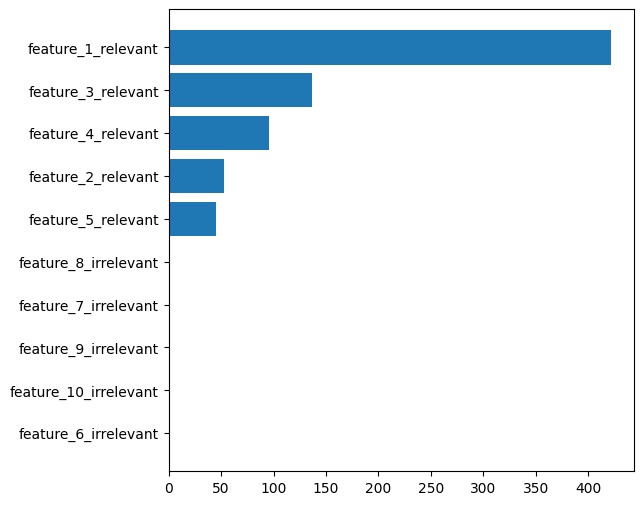

In [36]:
feature_importance_plot(fi_non_dynamicity_p)

## <span id="Third">3. Uplift Curve</span>

We are using the Filter method based on an uplift curve (Hu, 2022).

In [37]:
uplift_curve = UpliftCurveFilter(n_bins=n_bins)

In [38]:
fi_uc, fi_variables_uc = uplift_curve.calculate_feature_importance(df, feature_names)

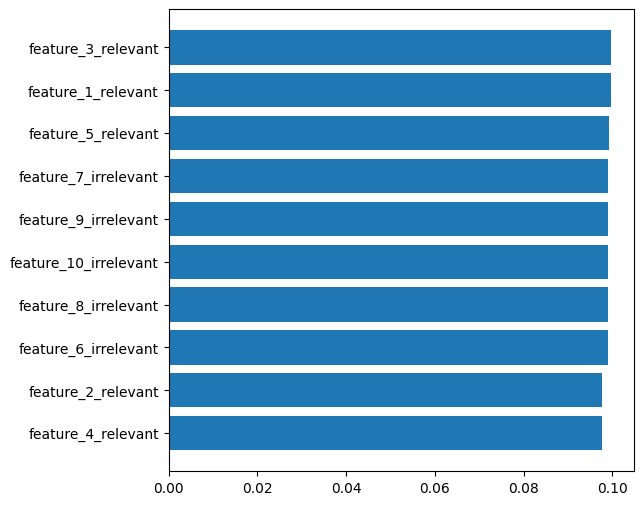

In [39]:
feature_importance_plot(fi_uc)

## <span id="Fourth">4. Net Information Value</span>

We are using the Net Information Value Filter Method (Larsen, 2010)

In [40]:
niv = NetInformationValueFilter(n_bins=n_bins)

In [41]:
fi_niv, fi_variables_niv = niv.calculate_feature_importance(df, feature_names)

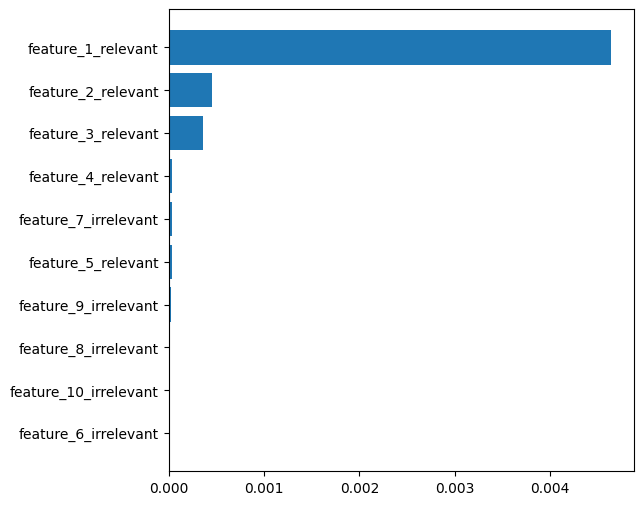

In [42]:
feature_importance_plot(fi_niv)

## <span id="Fifth">5. Feature Importance over Time (FIoT) with Divergence Filter</span>


In [43]:
def create_timeslots(start_day, end_day, unit, window):
    """
    Create different dates used for the dynamic feature selection method
    
    Args:
        start_day (int): Start day
        end_day (int): End day
        unit (int): Unit
        window (int): Window
    Returns
        date_pairs (list of tuples): List of pairs with start and end day
    """
    diff_in_days = end_day - start_day + 1
        
    day_pairs = []
    window_counter = 0
    for i in range(unit, diff_in_days + 1, unit):
        if i == unit:
            train_start_day = 1
        else:
            train_start_day = day_pairs[-1][1] + 1

        train_end_day = train_start_day + (unit - 1)
        day_pairs.append((train_start_day, train_end_day))
        window_counter += 1
        if window_counter == window:
            break
    
    return day_pairs

In [60]:
def plot_feature_importance_over_time(df, top_k, feature_col='feature', fontsize=12):
    feature_names = df[feature_col].to_list()
    feature_importances = df.iloc[:top_k,1:]
    num_dates = feature_importances.shape[1]
    dates_str = feature_importances.columns.to_list()
    
    fig, ax = plt.subplots(figsize=(10, 5), facecolor="white")
    ax.set_facecolor('white')
    
    plt.rcParams.update({
        'font.size': fontsize
    })
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    for index, row in feature_importances.iterrows():
        feature_name = feature_names[index]
        ax.plot(row.values, label=feature_name)
        
    ax.legend(facecolor="white")
    plt.xticks(range(0,num_dates), dates_str)
    
    plt.xticks(rotation=45)
    
    plt.show()

In [55]:
unit = 1
window = nr_days // unit
day_pairs = create_timeslots(1, nr_days, unit, window)
drop_columns_fs = ['day']

In [56]:
feature_importance_over_time_df = FeatureImportanceOverTime(method='divergence',
                                                            n_bins=n_bins,
                                                            divergence_method='KL',
                                                            date_col='day'
                                                           )

In [59]:
fiot_df, fiot_variables_df = feature_importance_over_time_df.calculate_feature_importance(df, window, day_pairs,
                                                                                          feature_names,
                                                                                          drop_columns_fs)

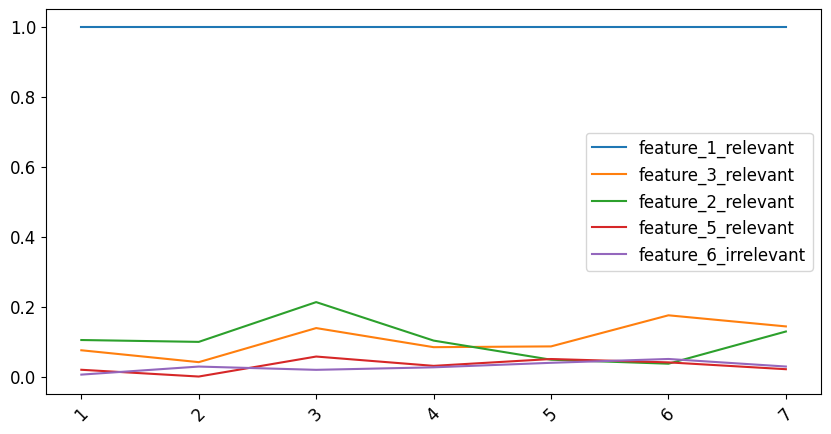

In [65]:
plot_feature_importance_over_time(fiot_df.iloc[:,:-1], 5)

Done!